Compare good topic models to raw keywords for query tests

## Imports, etc.

In [1]:
FILES = {'mle4600_adv_contextual_keywords.parquet':'mle4600_adv_contextual_keywords.parquet',
         'wiki.en.bin':'wiki.en.bin',
         'interests.tsv':'interests.tsv',
         'keywords.tsv':'keywords.tsv'}

In [92]:
import collections
import fasttext
import json
import numpy as np
import os
import pandas as pd
from plotnine import *
import sys

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Helper Functions

In [3]:
class JsonReader(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemming=False):
        self.stemming = stemming
        
        super(JsonReader).__init__()
    
    
    @staticmethod
    def _stem_and_add(json_str):
        """
        Transform each token into its stemmed substring,
        and build the dict as {stem: (sum of counts of words with this stem)}
        """
        stemmed_counts = collections.defaultdict(int)        
        stem = nltk.stem.SnowballStemmer('english')
        
        json_dict = json.loads(json_str)
        
        for k in json_dict.keys():
            stemmed_counts[stem.stem(k)] += json_dict[k]
        
        return stemmed_counts
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):        
        if self.stemming:
            return X.apply(self._stem_and_add)
        else:
            return X.apply(json.loads)

In [4]:
class LatentPipeline():
    
    def _get_pipeline(self):
        raise NotImplementedError
    
    def _topic_words(self):
        raise NotImplementedError
    
    def __init__(self, data, **kwargs):
        
        self.variance_threshold=0.5
        self.top_words_per_topic=10
        self.data = data
        self.__dict__.update(kwargs)
        
        
        self.pipeline = self._get_pipeline(**kwargs)

        self.pipeline.fit(data['keywords_json'])
        
        self.topic_words = self._topic_words()
        

    @property
    def predicted(self):
        
        return self._predict(self.data['keywords_json'])
        
        
    def _predict(self, input_data):
        
        return self.pipeline.transform(input_data)
        
        
    def _top_variance_topic_weights(self, input_data):
        raise NotImplementedError
           
    def _top_variance_topics(self, input_data):
        raise NotImplementedError

    @property
    def top_variance_topics(self):
        
        return self._top_variance_topics(self.data['keywords_json'])

    
    @staticmethod
    def _normalize_rows(x):
        centered_x = x - np.expand_dims(np.min(x,axis=1),-1)
        
        return centered_x / np.expand_dims(np.sum(centered_x,axis=1),-1)
    
    
    def demonstrate(self, data=None):
        """
        Show the top keywords produced by the topic model based on the inputted keywords
        """
        
        if data is None:
            data=self.data
        
        these_top_variance_topics = zip(
                                        self._top_variance_topics(data['keywords_json']),
                                        self._top_variance_topic_weights(data['keywords_json']))

        for i, (ids, weights) in enumerate(these_top_variance_topics):
            
            print(f"{data.iloc[i]['descr']} [Interest {data.iloc[i]['interest_id']}]")            
            print("=============================================================")


            for (topic_id, weight) in zip(ids, weights):
                print(f"Topic {topic_id}({np.round(weight,3)}):\n{self.topic_words[topic_id]}")
            print('\n')
            
    
    def top_variance_sentence(self, input_data):
        
        top_variance_topics = self._top_variance_topics(input_data['keywords_json'])
        
        return top_variance_topics.apply(lambda x: " ".join([" ".join(self.topic_words[topic]) for topic in x]))

In [59]:
class LDAPipeline(LatentPipeline):
    
    def _get_pipeline(self, **kwargs):        
        
        var_dict = {
            'stemming':False,
            'n_components':10
        }
        
        var_dict.update(**kwargs)
            
        return Pipeline([

            # Reads json strings into word:count dicts
            ('json_reader', JsonReader(stemming=var_dict['stemming'])),

            # Composes the dicts into vectors, where the cardinality
            # of the vector is that of all dict keys in all rows
            ('dict_vectorizer', DictVectorizer()),

            # word:count row-column pairs are normalized via TF-IDF,
            # producing a matrix
            ('tfidf_transformer', TfidfTransformer()),

            # Latent Dirichlet Analysis is performed on the TF-IDF matrix
            ('model', LatentDirichletAllocation(n_components=var_dict['n_components'],max_iter=10,learning_method='batch',verbose=1))    
        ])

    @property
    def words(self):
        
        return self.pipeline['dict_vectorizer'].get_feature_names()
    
    
    def _topic_words(self):
        
        top_words_per_topic = self.top_words_per_topic
        
        word_idx = (
            self.pipeline['model']
            .components_
            .argsort(axis=1)[:,-(top_words_per_topic-1):-1]
        )
        
        return [[self.words[x] for x in row] for row in word_idx]
    
    
    def _top_variance_topic_weights(self, input_data):
        """
        """

        predicted_val = self._predict(input_data)

        ordered_val   = np.sort(predicted_val, axis=1)

        
        ordered_x_row_ids = predicted_val.argsort(axis=1) + 1 # 1-indexed
        sorted_x          = np.sort(predicted_val, axis=1)
        sorted_x_cumsum   = np.cumsum(sorted_x, axis=1)

        # produce a mask where desired indices have a mask of 1 and 
        # undesired have a mask of -1        
        element_mask = ((sorted_x_cumsum > (1-self.variance_threshold))*2.0) - 1 

        # a 1d array of sets, where each set is correctly 0-indexed column IDs
        desired_ids_by_row = []
        
        masked = ordered_x_row_ids * element_mask
        
        sorted_x_flip = np.flip(sorted_x, axis=1)
        
        for i, row in enumerate(np.flip(masked, axis=1)):
            desired_ids_by_row.append([predicted_val[i,int(x-1)] for x in row if x > 0])
        
        return pd.Series(desired_ids_by_row)
    
    
    def _top_variance_topics(self, input_data):
        """
        For a given amount of desired variance (0 < x <= 1) return for each row
        of the predicted topic model the smallest number of topics
        necessary to account for that variance.

        e.g. if a row is 

        [0.02, 0.18, 0.28, 0.02, 0.42, 0.02, 0.02, 0.02, 0.02, 0.02]

        top_variance_topics(x,0.3) -> 4
        top_variance_topics(x,0.5) -> 2,4
        top_variance_topics(x,0.8) -> 1,2,4
        """

        predicted_val = self._predict(input_data) 
        
        ordered_x_row_ids = predicted_val.argsort(axis=1) + 1 # 1-indexed
        sorted_x          = np.sort(predicted_val, axis=1)
        sorted_x_cumsum   = np.cumsum(sorted_x, axis=1)

        # produce a mask where desired indices have a mask of 1 and 
        # undesired have a mask of -1        
        element_mask = ((sorted_x_cumsum > (1-self.variance_threshold))*2.0) - 1 

        # a 1d array of sets, where each set is correctly 0-indexed column IDs
        desired_ids_by_row = []
        
        masked = ordered_x_row_ids * element_mask
        
        for i, row in enumerate(np.flip(masked, axis=1)):
            desired_ids_by_row.append([int(x-1) for x in row if x > 0])
        
        return pd.Series(desired_ids_by_row)

In [6]:
class LSIPipeline(LatentPipeline):
    
    def _get_pipeline(self, **kwargs):
        
        var_dict = {
            'stemming':False,
            'n_components':10
        }
        
        var_dict.update(**kwargs)
        
        return Pipeline([

            # Reads json strings into word:count dicts
            ('json_reader', JsonReader(stemming=var_dict['stemming'])),

            # Composes the dicts into vectors, where the cardinality
            # of the vector is that of all dict keys in all rows
            ('dict_vectorizer', DictVectorizer()),

            # word:count row-column pairs are normalized via TF-IDF,
            # producing a matrix
            ('tfidf_transformer', TfidfTransformer()),

            # Latent Semantic Indexing is performed on the TF-IDF matrix
            ('model', TruncatedSVD(n_components=var_dict['n_components']))    
        ])
    
    
    @property
    def words(self):
        
        return self.pipeline['dict_vectorizer'].get_feature_names()
        
    def _topic_words(self):
        
        top_words_per_topic = self.top_words_per_topic
        
        word_idx = (
            self.pipeline['model']
            .components_
            .argsort(axis=1)[:,-(top_words_per_topic-1):]
        )
        
        return [[self.words[x] for x in row[::-1]] for row in word_idx]


    def _top_variance_topics(self, input_data):
        """
        For a given amount of desired variance (0 < x <= 1) return for each row
        of the predicted topic model the smallest number of topics
        necessary to account for that variance.

        e.g. if a row is 

        [0.02, 0.18, 0.28, 0.02, 0.42, 0.02, 0.02, 0.02, 0.02, 0.02]

        top_variance_topics(x,0.3) -> 4
        top_variance_topics(x,0.5) -> 2,4
        top_variance_topics(x,0.8) -> 1,2,4
        """

        predicted_val = self._predict(input_data)
        
        ordered_x_row_ids = predicted_val.argsort(axis=1) 
        sorted_x          = np.sort(predicted_val, axis=1)
        sorted_x_cumsum   = np.cumsum(self._normalize_rows(sorted_x), axis=1)
        
        element_mask = ((sorted_x_cumsum > (1-self.variance_threshold))*2.0) - 1 
        

        desired_ids_by_row = []
        
        masked = ordered_x_row_ids * element_mask
        
        for i, row in enumerate(np.flip(masked, axis=1)):
            desired_ids_by_row.append([int(x) for x in row if x >= 0])
        
        return pd.Series(desired_ids_by_row)
    
    
    def _top_variance_topic_weights(self, input_data):

        predicted_val = self._normalize_rows(self._predict(input_data))

        ordered_val   = np.sort(predicted_val, axis=1)

        
        ordered_x_row_ids = predicted_val.argsort(axis=1) + 1 # 1-indexed
        sorted_x          = np.sort(predicted_val, axis=1)
        sorted_x_cumsum   = np.cumsum(sorted_x, axis=1)

        # produce a mask where desired indices have a mask of 1 and 
        # undesired have a mask of -1        
        element_mask = ((sorted_x_cumsum > (1-self.variance_threshold))*2.0) - 1 

        # a 1d array of sets, where each set is correctly 0-indexed column IDs
        desired_ids_by_row = []
        
        masked = ordered_x_row_ids * element_mask
                
        for i, row in enumerate(np.flip(masked, axis=1)):
            desired_ids_by_row.append([predicted_val[i,int(x-1)] for x in row if x > 0])
        
        return pd.Series(desired_ids_by_row)

In [7]:
from scipy.stats import rankdata
from sklearn.metrics.pairwise import cosine_similarity

class ColumnComparison():
    
    def __init__(self, basis_text: pd.Series, compare_text: pd.Series, model: fasttext.FastText):
        
        assert basis_text.shape[0] == compare_text.shape[0], "basis text and compare text Series must have same length"
        
        self.basis_text = basis_text
        self.compare_text = compare_text
        self.basis_vectors = basis_text.apply(model.get_sentence_vector)
        self.compare_vectors = compare_text.apply(model.get_sentence_vector)
        
    @property
    def distance(self) -> pd.Series:
        
        distance_arr = 1.0 - cosine_similarity(
            np.vstack(self.basis_vectors),
            np.vstack(self.compare_vectors)
        )
                
        assert np.array_equal(distance_arr.shape, 
                              np.array([self.basis_text.shape[0], self.compare_text.shape[0]]))
        
        return distance_arr
    
    @property
    def self_distance(self) -> np.ndarray:
        """
        """
        
        return np.diag(self.distance)
    
    @property
    def best_basis_compare_distance(self) -> np.ndarray:
        """
        Basis is X, Compare is Y, so for the Xth row
        find the smallest element of Y
        """
        
        # min along axis 1
        return np.min(self.distance, axis=1)
    
    @property
    def best_compare_for_basis(self) -> pd.Series:
        """
        Target is X, Compare is Y, so for the Xth row
        find which element of Y is the smallest
        """
        
        # min along axis 1
        min_indices = np.argmin(self.distance, axis=1)
        return self.compare_text.values[tuple([min_indices])]
        
    @property
    def basis_of_best_compare(self) -> pd.Series:
        """
        For an entry of self.basis_text, first find the 
        self.compare_text that is nearest by cosine distance 
        and get the basis corresponding to that match.
        """
        
        min_indices = np.argmin(self.distance, axis=0)
        return self.basis_text.values[tuple([min_indices])]
    
    @property
    def basis_self_rank(self) -> np.ndarray:
        """
        For a given value in self.compare_text, rank
        self.basis_text in terms of closeness by cosine distance.
        Return the rank of the basis corresponding to the compare_text.
        """
        
        # rank down the column, i.e. rank basis in terms of each compare
        return np.diag(rankdata(self.distance, axis=0))

## Data Gathering

In [8]:
ft_model = fasttext.load_model(FILES['wiki.en.bin'])

### Keywords API

In [9]:
interests_df = pd.read_table(FILES['interests.tsv'],
                             names=['interest_id','interest_type_id','descr'])

interests_df.head(n=3)

,interest_id,interest_type_id,descr
0,36864,110,Vegetarians
1,77825,110,Small Business Administration Cares Act Resear...
2,1,110,Fitness Enthusiasts


In [10]:
keywords_from_api_df = pd.read_table(FILES['keywords.tsv'],
                             names=['interest_id','keyword','n'])

keywords_from_api_df.head(n=3)

,interest_id,keyword,n
0,36864,desserts,13
1,36864,gluten,5
2,36864,quick,5


In [11]:
keyword_api_df = pd.merge(
    interests_df,
    keywords_from_api_df, on='interest_id', how='left')

keyword_api_df.head()

,interest_id,interest_type_id,descr,keyword,n
0,36864,110,Vegetarians,desserts,13
1,36864,110,Vegetarians,gluten,5
2,36864,110,Vegetarians,quick,5
3,36864,110,Vegetarians,foods,14
4,36864,110,Vegetarians,wholesome,5


In [12]:
keyword_api_dict = collections.defaultdict(dict)

for i, r in keyword_api_df.iterrows():
    keyword_api_dict[r['descr']][r['keyword']] = r['n']

In [13]:
keyword_api_json_df = (
    pd.merge(
        
        pd.DataFrame([(k, json.dumps(keyword_api_dict[k])) for k in keyword_api_dict.keys()])
        .rename(columns={0:'descr',
                         1:'keywords_json'}),
        
        keyword_api_df[['interest_id','descr']].drop_duplicates(),
        
        on='descr',
        how='left')
    .assign(keyword_list = lambda x: x['keywords_json'].apply(lambda y: list(json.loads(y).keys())))
)

print(keyword_api_json_df.shape)

keyword_api_json_df.head(n=3)

(2747, 4)


,descr,keywords_json,interest_id,keyword_list
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha..."
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation..."
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,..."


In [14]:
keyword_interests = keyword_api_json_df['interest_id'].tolist()

# ensure each row is a unique interest
assert keyword_api_json_df['interest_id'].nunique() == keyword_api_json_df.shape[0]

### Advanced Contextual

In [15]:
adv_cont_keywords_df = (
    pd.read_parquet(FILES['mle4600_adv_contextual_keywords.parquet'])
        .assign(keyword_list = lambda x: x['keywords_json'].apply(lambda y: list(json.loads(y).keys())))    
)

print(adv_cont_keywords_df.shape)

# ensure each row is a unique interest
assert adv_cont_keywords_df['interest_id'].nunique() == adv_cont_keywords_df.shape[0]

adv_cont_keywords_df.head(n=3)

(4525, 10)


,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
0,110,17744,46444,Vegans Q1 2018 (Oatly),Vegans Q1 2018 (Oatly),"[blissfulbasil.com, rabbitandwolves.com, emili...","[1hv6i, 1lyy4, 1mj5v, 1mp53, 1qxr8, 1jc3a, 1ih...",3297,"{""vegan"": 344, ""sauce"": 306, ""recipe"": 254, ""t...","[vegan, sauce, recipe, tofu, soup, salad, rice..."
1,110,56010,627953,Wedding Content Researchers DNU,Wedding Content Researchers DNU,"[mywedding.com, travelfashiongirl.com, wedding...","[mjkp, 1l0k1, 1ncn8, 1dbyf, fhmi, 2xg, qwd1, 1...",21466,"{""wedding"": 3418, ""dress"": 702, ""venue"": 692, ...","[wedding, dress, venue, guests, wedding day, c..."
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."


### Common Audiences

In [96]:
adv_cont_keywords_df.head()

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
0,110,17744,46444,Vegans Q1 2018 (Oatly),Vegans Q1 2018 (Oatly),"[blissfulbasil.com, rabbitandwolves.com, emili...","[1hv6i, 1lyy4, 1mj5v, 1mp53, 1qxr8, 1jc3a, 1ih...",3297,"{""vegan"": 344, ""sauce"": 306, ""recipe"": 254, ""t...","[vegan, sauce, recipe, tofu, soup, salad, rice..."
1,110,56010,627953,Wedding Content Researchers DNU,Wedding Content Researchers DNU,"[mywedding.com, travelfashiongirl.com, wedding...","[mjkp, 1l0k1, 1ncn8, 1dbyf, fhmi, 2xg, qwd1, 1...",21466,"{""wedding"": 3418, ""dress"": 702, ""venue"": 692, ...","[wedding, dress, venue, guests, wedding day, c..."
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
3,110,94779,653665,Resort Vacationers,Resort Vacationers,"[travelpulse.com, aviewfrommyseat.com, allhiph...","[mjkp, 12g0d, 1p4o4, 1nayh, 1k3bc, 1o59r, f9h5...",1047,"{""wedding"": 153, ""venue"": 88, ""guests"": 38, ""c...","[wedding, venue, guests, cruise, caribbean, pa..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."


In [97]:
common_audiences_list = list(
    set(keyword_api_json_df['interest_id'].tolist())
        .intersection(set(adv_cont_keywords_df['interest_id'].tolist()))
)

len(common_audiences_list)

1991

In [17]:
# prediction_list = keyword_api_json_df.query('descr in @common_audiences')['interest_id'].tolist()
# prediction_list

In [18]:
prediction_list = [43, 17269, 5984, 6223, 19621, 11445, 11462, 11620, 11658, 11857]

## Name vs Keyword Rankings

### Naive Keyword API

In [104]:
keyword_naive = keyword_api_json_df.copy().query('interest_id.isin(@common_audiences_list)')

keyword_naive.head(n=3)

,descr,keywords_json,interest_id,keyword_list
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha..."
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation..."
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,..."


In [105]:
keyword_compare = ColumnComparison(basis_text   =keyword_naive['descr'],
                                   compare_text =keyword_naive['keyword_list'].apply(lambda x: ' '.join(x)),
                                   model        =ft_model)

In [106]:
keyword_naive.loc[:,'self_distance']        = keyword_compare.self_distance
keyword_naive.loc[:,'closest_to_name_dist'] = keyword_compare.best_basis_compare_distance
keyword_naive.loc[:,'best_keywords']        = keyword_compare.best_compare_for_basis
keyword_naive.loc[:,'best_interest_name']   = keyword_compare.basis_of_best_compare
keyword_naive.loc[:,'self_search_rank']     = keyword_compare.basis_self_rank

keyword_naive.head(n=3)

,descr,keywords_json,interest_id,keyword_list,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",0.394989,0.387600,gluten desserts dairy-free comforting foods wh...,Nutrition Wellness and Recipe Content Readers,78.0
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",0.304923,0.268646,college capital education software owners lead...,Investment Banking Professionals,15.0
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",0.419063,0.383463,camping owners cycling discussion used enthusi...,Nutrition Wellness and Recipe Content Readers,381.0


### Naive Advanced Contextual

In [107]:
adv_cont_naive = adv_cont_keywords_df.copy().query('interest_id.isin(@common_audiences_list)')

adv_cont_naive.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m..."


In [108]:
adv_cont_compare = ColumnComparison(basis_text   =adv_cont_naive['descr'],
                                    compare_text =adv_cont_naive['keyword_list'].apply(lambda x: ' '.join(x)),
                                    model        =ft_model)

In [109]:
adv_cont_naive.loc[:,'self_distance']        = adv_cont_compare.self_distance
adv_cont_naive.loc[:,'closest_to_name_dist'] = adv_cont_compare.best_basis_compare_distance
adv_cont_naive.loc[:,'best_keywords']        = adv_cont_compare.best_compare_for_basis
adv_cont_naive.loc[:,'best_interest_name']   = adv_cont_compare.basis_of_best_compare
adv_cont_naive.loc[:,'self_search_rank']     = adv_cont_compare.basis_self_rank

adv_cont_naive.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",0.263239,0.215517,project excel apqc template charter project ma...,"Assorted Topics (Weather, Movie Studios, Peopl...",4.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",0.483111,0.398884,paris pageoptions france enquiry pr parisbytra...,Washington County and Local Fair Visitors,794.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",0.344463,0.312387,partners cloud-like solutions malware iso chan...,Computer Processor and Data Center Decision Ma...,109.0


### TopicModel Keyword API

#### Build LSI Model

In [110]:
keyword_lsi = keyword_api_json_df.copy().query('interest_id.isin(@common_audiences_list)')

keyword_lsi.head(n=3)

,descr,keywords_json,interest_id,keyword_list
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha..."
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation..."
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,..."


In [111]:
kw_lsi_pipe = LSIPipeline(keyword_lsi, n_components=250, variance_threshold=0.02)
kw_lsi_pipe.demonstrate(
    keyword_lsi.query('interest_id.isin(@prediction_list)')
)

Apartment Hunters [Interest 43]
Topic 44(0.007):
['sport', 'football', 'golf', 'job', 'jobs', 'nfl', 'english', 'fishing', 'black']
Topic 83(0.007):
['wedding', 'arizona', 'transfers', 'homes', 'conservative', 'dresses', 'kansas', 'football', 'missouri']
Topic 249(0.007):
['hawaii', 'vancouver', 'great', 'apartments', 'headlines', 'philadelphia', 'topics', 'math', 'utah']


At-Home Gym Intenders [Interest 17269]
Topic 29(0.009):
['florida', 'york', 'bike', 'cycling', 'texas', 'running', 'bikes', 'road', 'movie']
Topic 23(0.008):
['india', 'bike', 'colorado', 'cycling', 'bollywood', 'mountain', 'indian', 'english', 'movie']
Topic 0(0.008):
['sports', 'entertainment', 'fan', 'weather', 'politics', 'health', 'follow', 'clock', 'yes']


Readers of Indian Content [Interest 5984]
Topic 22(0.013):
['india', 'florida', 'bollywood', 'movie', 'indian', 'telugu', 'headlines', 'cricket', 'hindi']
Topic 23(0.011):
['india', 'bike', 'colorado', 'cycling', 'bollywood', 'mountain', 'indian', 'english'

#### Build LDA Model

In [112]:
keyword_lda = keyword_api_json_df.copy().query('interest_id.isin(@common_audiences_list)')

keyword_lda.head(n=3)

,descr,keywords_json,interest_id,keyword_list
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha..."
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation..."
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,..."


In [113]:
kw_lda_pipe = LDAPipeline(keyword_lda, n_components=250, variance_threshold=0.3)
kw_lda_pipe.demonstrate(
    keyword_lda.query('interest_id.isin(@prediction_list)')
)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Apartment Hunters [Interest 43]
Topic 23(0.225):
['landlords', 'condos', 'exterior', 'listing', 'landscape', 'built', 'housing', 'apartment']
Topic 172(0.192):
['career', 'sidearm', 'learfield', 'img', 'university', 'jobs', 'college', 'job']


At-Home Gym Intenders [Interest 17269]
Topic 224(0.244):
['gym', 'muscle', 'workout', 'running', 'fit', 'nutrition', 'workouts', 'strength']
Topic 229(0.196):
['race', 'triathlon', 'bicycle', 'road', 'mountain', 'running', 'bikes', 'cycling']


Readers of Indian Content [Interest 5984]
Topic 32(0.592):
['headlines', 'hindi', 'telangana', 'cricket', 'cinema', 'movie', 'telugu', 'bollywood']


Language Learners [Interest 6223]
Topic 56(0.259):
['encyclopedia', 'm

#### LSI Keyword Comparisons

In [122]:
keyword_lsi.loc[:,'keyword_sentence'] = kw_lsi_pipe.top_variance_sentence(
                                            keyword_lsi
                                        )
keyword_lsi.head()

,descr,keywords_json,interest_id,keyword_list,keyword_sentence
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",healthy delicious kitchen family cooking women...
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",financial software investment technology fashi...
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",sports entertainment fan weather politics heal...
3,Remdesivir Information Researchers,"{""medical"": 4, ""movie"": 8, ""channel"": 4, ""poli...",77824,"[medical, movie, channel, political, focus, sp...",sports entertainment fan weather politics heal...
4,Gamers,"{""3ds"": 5, ""mods"": 4, ""achievements"": 5, ""movi...",2,"[3ds, mods, achievements, movie, wiki, collect...",games gaming movie movies music technology del...


In [123]:
keyword_lsi_compare = ColumnComparison(basis_text   =keyword_lsi['descr'],
                                       compare_text =keyword_lsi['keyword_sentence'].astype(str),
                                       model        =ft_model)

In [124]:
keyword_lsi.loc[:,'self_distance']        = keyword_lsi_compare.self_distance
keyword_lsi.loc[:,'closest_to_name_dist'] = keyword_lsi_compare.best_basis_compare_distance
keyword_lsi.loc[:,'best_keywords']        = keyword_lsi_compare.best_compare_for_basis
keyword_lsi.loc[:,'best_interest_name']   = keyword_lsi_compare.basis_of_best_compare
keyword_lsi.loc[:,'self_search_rank']     = keyword_lsi_compare.basis_self_rank

keyword_lsi.head(n=3)

,descr,keywords_json,interest_id,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",healthy delicious kitchen family cooking women...,0.482565,0.482565,healthy delicious kitchen family cooking women...,Nutrition Wellness and Recipe Content Readers,991.0
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",financial software investment technology fashi...,0.314720,0.291647,financial software investment technology fashi...,Health and Fitness Book Readers,41.0
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",sports entertainment fan weather politics heal...,0.424643,0.385832,enthusiasts discussion owners car truck cars m...,Canada Shopping - Lifestyle and Mommy Blogs,514.0


#### LDA Keyword Comparisons

In [125]:
keyword_lda.loc[:,'keyword_sentence'] = kw_lda_pipe.top_variance_sentence(
                                            keyword_lda
                                        )
keyword_lda.head()

,descr,keywords_json,interest_id,keyword_list,keyword_sentence
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",family ingredients youtube cook vegan healthy ...
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",investment clients legal law accounting tax so...
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",sport travel music advice beauty health fashio...
3,Remdesivir Information Researchers,"{""medical"": 4, ""movie"": 8, ""channel"": 4, ""poli...",77824,"[medical, movie, channel, political, focus, sp...",institute weather economic technology entertai...
4,Gamers,"{""3ds"": 5, ""mods"": 4, ""achievements"": 5, ""movi...",2,"[3ds, mods, achievements, movie, wiki, collect...",gamers ps4 warcraft walkthroughs wow xbox nint...


In [126]:
keyword_lda_compare = ColumnComparison(basis_text   =keyword_lda['descr'],
                                       compare_text =keyword_lda['keyword_sentence'].astype(str),
                                       model        =ft_model)

In [127]:
keyword_lda.loc[:,'self_distance']        = keyword_lda_compare.self_distance
keyword_lda.loc[:,'closest_to_name_dist'] = keyword_lda_compare.best_basis_compare_distance
keyword_lda.loc[:,'best_keywords']        = keyword_lda_compare.best_compare_for_basis
keyword_lda.loc[:,'best_interest_name']   = keyword_lda_compare.basis_of_best_compare
keyword_lda.loc[:,'self_search_rank']     = keyword_lda_compare.basis_self_rank

keyword_lda.head(n=3)

,descr,keywords_json,interest_id,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",family ingredients youtube cook vegan healthy ...,0.447512,0.447238,meal cooking kitchen diet dinner keto family h...,Cooking Recipe & Ingredient Researchers,34.0
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",investment clients legal law accounting tax so...,0.396439,0.316889,investment clients legal law accounting tax so...,Investment Banking Professionals,24.0
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",sport travel music advice beauty health fashio...,0.477147,0.391453,sport travel music advice beauty health fashio...,Cosmetics and Beauty Shoppers,217.0


### TopicModel Advanced Contextual

#### Build LSI Model

In [128]:
ac_lsi = adv_cont_keywords_df.copy().query('interest_id.isin(@common_audiences_list)')

ac_lsi.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m..."


In [129]:
ac_lsi_pipe = LSIPipeline(ac_lsi, n_components=250, variance_threshold=0.02)
ac_lsi_pipe.demonstrate(
    ac_lsi.query('interest_id.isin(@prediction_list)')
)

Italy Cluster [Interest 11462]
Topic 0(0.01):
['trump', 'capitol', 'covid-19', 'donald trump', 'vaccine', 'congress', 'senate', 'joe biden', 'white house']
Topic 11(0.009):
['united states', 'new york', 'europe', 'bts', 'students', 'encyclopedia.com', 'england', 'company', 'london']
Topic 16(0.007):
['trail', 'hike', 'bike', 'bikes', 'colorado', 'park', 'georgia', 'trails', 'boulder']


Language Learners [Interest 6223]
Topic 241(0.009):
['cutimes.com', 'source', 'bison', 'credit unions', 'rma', 'utah', 'meatingplace', 'kentucky', 'tennessee']
Topic 212(0.007):
['nhra', 'likes', 'kitchen magpie', 'campground', 'www.pinterest.com', 'sierra club', 'instant pot', 'san francisco', 'financial samurai']
Topic 193(0.007):
['f1', 'mercedes', 'aol mail', 'kitchen magpie', 'wrc', 'autosport', 'indiana', 'ferrari', 'formula']


Minnesota Local News Cluster [Interest 11445]
Topic 86(0.013):
['minnesota', 'south dakota', 'north dakota', 'duluth', 'twins', 'bemidji', 'reuters', 'florida', 'fargo']
T

#### Build LDA Model

In [130]:
ac_lda = adv_cont_keywords_df.copy().query('interest_id.isin(@common_audiences_list)')

ac_lda.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m..."


In [131]:
ac_lda_pipe = LDAPipeline(ac_lda, n_components=250, variance_threshold=0.3)

ac_lda_pipe.demonstrate(
    ac_lda.query('interest_id.isin(@prediction_list)')
)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Italy Cluster [Interest 11462]
Topic 137(0.328):
['italy', 'museum', 'trip', 'fodor', 'hotel', 'travel', 'beaches', 'beach']


Language Learners [Interest 6223]
Topic 167(0.584):
['dict.cc', 'luis miguel', 'translation', 'und', 'werden', 'beitragenden', 'sprachaufnahmen', 'reproducción de twitter']


Minnesota Local News Cluster [Interest 11445]
Topic 221(0.325):
['minnesota department of health', 'gout attacks', 'oa', 'ra', 'nsaids', 'rheumatoid arthritis', 'gout', 'bemidji']


Construction Apparel [Interest 11658]
Topic 145(0.7):
['oil', 'truck', 'dog', 'battery', 'fuel', 'boat', 'ford', 'likes']


Readers of Indian Content [Interest 5984]
Topic 115(0.517):
['nintendo switch', 'apple arcade', 'japa

#### LSI Keyword Comparisons

In [194]:
ac_lsi.loc[:,'keyword_sentence'] = ac_lsi_pipe.top_variance_sentence(
                                            ac_lsi
                                        )
ac_lsi.head()

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",amd cpu intel nvidia gpu overclocking performa...,0.430450,0.283431,government requirements ports of call health a...,Computer Processor and Data Center Decision Ma...,186.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",venezuela por para madrid dólares ella cuba go...,0.792272,0.451391,india salem marvel cw new hampshire disney mai...,Cinco de Mayo Celebrators,1553.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",game app store switcharcade round-up ios and a...,0.488112,0.372408,asientos toyota dental practice apple carplay ...,Smartphones,175.0
10,112,11309,40635,Rochester New York Cluster,People in this audience are interested in news...,"[wblk.com, wivb.com, lockportjournal.com, buff...","[lfu2, 1kt8g, fsxp, fy42, isgl, d2k5, u4c6, 1k...",3903,"{""buffalo"": 416, ""new york"": 404, ""capitol"": 2...","[buffalo, new york, capitol, covid-19, vaccine...",trump capitol covid-19 donald trump vaccine co...,0.658346,0.374563,router mac wall file ram windows paint wood di...,Summer Festivals and Fairs Visitors,1352.0
11,110,6120,25960,Readers of Puerto Rican Content,People reading news from Puerto Rican media so...,"[venezuelaaldia.com, periodistadigital.com, co...","[1p8mt, um76, 1je4h, 1ip9i, scte, uxk6, 1jrig,...",316,"{""puerto rico"": 28, ""venezuela"": 25, ""para"": 9...","[puerto rico, venezuela, para, por, gobierno, ...",engine likes ford fuel battery truck car gm oi...,0.433784,0.325940,sandwich mcdonald feet chipotle pdt sonoma cou...,Santa Cruz Trip Planners,15.0


In [195]:
ac_lsi_compare = ColumnComparison(basis_text   =ac_lsi['descr'],
                                  compare_text =ac_lsi['keyword_sentence'].astype(str),
                                  model        =ft_model)

In [196]:
ac_lsi.loc[:,'self_distance']        = ac_lsi_compare.self_distance
ac_lsi.loc[:,'closest_to_name_dist'] = ac_lsi_compare.best_basis_compare_distance
ac_lsi.loc[:,'best_keywords']        = ac_lsi_compare.best_compare_for_basis
ac_lsi.loc[:,'best_interest_name']   = ac_lsi_compare.basis_of_best_compare
ac_lsi.loc[:,'self_search_rank']     = ac_lsi_compare.basis_self_rank

ac_lsi.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",amd cpu intel nvidia gpu overclocking performa...,0.428130,0.276852,bourbon global shipping program global shippin...,Computer Processor and Data Center Decision Ma...,274.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",venezuela por para madrid dólares ella cuba go...,0.635929,0.449575,andover santa cruz santa cruz county a360 mont...,Cinco de Mayo Celebrators,1344.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",game app store switcharcade round-up ios and a...,0.464412,0.372705,bourbon global shipping program global shippin...,Computer Processor and Data Center Decision Ma...,714.5


#### LDA Keyword Comparisons

In [197]:
ac_lda.loc[:,'keyword_sentence'] = ac_lda_pipe.top_variance_sentence(
                                            ac_lda
                                        )
ac_lda.head()

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",high-a grade c prospect good chance double-a p...,0.430450,0.283431,government requirements ports of call health a...,Computer Processor and Data Center Decision Ma...,186.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",estados unidos más dólares cuba ella madrid pa...,0.792272,0.451391,india salem marvel cw new hampshire disney mai...,Cinco de Mayo Celebrators,1553.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",nintendo switch apple arcade japan ios touchar...,0.488112,0.372408,asientos toyota dental practice apple carplay ...,Smartphones,175.0
10,112,11309,40635,Rochester New York Cluster,People in this audience are interested in news...,"[wblk.com, wivb.com, lockportjournal.com, buff...","[lfu2, 1kt8g, fsxp, fy42, isgl, d2k5, u4c6, 1k...",3903,"{""buffalo"": 416, ""new york"": 404, ""capitol"": 2...","[buffalo, new york, capitol, covid-19, vaccine...",italy museum trip fodor hotel travel beaches b...,0.658346,0.374563,router mac wall file ram windows paint wood di...,Summer Festivals and Fairs Visitors,1352.0
11,110,6120,25960,Readers of Puerto Rican Content,People reading news from Puerto Rican media so...,"[venezuelaaldia.com, periodistadigital.com, co...","[1p8mt, um76, 1je4h, 1ip9i, scte, uxk6, 1jrig,...",316,"{""puerto rico"": 28, ""venezuela"": 25, ""para"": 9...","[puerto rico, venezuela, para, por, gobierno, ...",fox43 el precio accord k24a2 rachel levine cub...,0.433784,0.325940,sandwich mcdonald feet chipotle pdt sonoma cou...,Santa Cruz Trip Planners,15.0


In [198]:
ac_lda_compare = ColumnComparison(basis_text   =ac_lda['descr'],
                                  compare_text =ac_lda['keyword_sentence'].astype(str),
                                  model        =ft_model)

In [199]:
ac_lda.loc[:,'self_distance']        = ac_lda_compare.self_distance
ac_lda.loc[:,'closest_to_name_dist'] = ac_lda_compare.best_basis_compare_distance
ac_lda.loc[:,'best_keywords']        = ac_lda_compare.best_compare_for_basis
ac_lda.loc[:,'best_interest_name']   = ac_lda_compare.basis_of_best_compare
ac_lda.loc[:,'self_search_rank']     = ac_lda_compare.basis_self_rank

ac_lda.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",high-a grade c prospect good chance double-a p...,0.430450,0.283431,government requirements ports of call health a...,Computer Processor and Data Center Decision Ma...,186.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",estados unidos más dólares cuba ella madrid pa...,0.792272,0.451391,india salem marvel cw new hampshire disney mai...,Cinco de Mayo Celebrators,1553.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",nintendo switch apple arcade japan ios touchar...,0.488112,0.372408,asientos toyota dental practice apple carplay ...,Smartphones,175.0


## Query Result Comparisons

### Rank example

In [171]:
keyword_naive[['descr','self_distance','closest_to_name_dist','keywords_json','best_keywords','best_interest_name','self_search_rank']].head(n=1)

,descr,self_distance,closest_to_name_dist,keywords_json,best_keywords,best_interest_name,self_search_rank
0,Vegetarians,0.394989,0.3876,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",gluten desserts dairy-free comforting foods wh...,Nutrition Wellness and Recipe Content Readers,78.0


### Rank Data

In [200]:
keyword_naive.head(n=3)

,descr,keywords_json,interest_id,keyword_list,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",0.394989,0.387600,gluten desserts dairy-free comforting foods wh...,Nutrition Wellness and Recipe Content Readers,78.0
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",0.304923,0.268646,college capital education software owners lead...,Investment Banking Professionals,15.0
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",0.419063,0.383463,camping owners cycling discussion used enthusi...,Nutrition Wellness and Recipe Content Readers,381.0


In [201]:
adv_cont_naive.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",0.263239,0.215517,project excel apqc template charter project ma...,"Assorted Topics (Weather, Movie Studios, Peopl...",4.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",0.483111,0.398884,paris pageoptions france enquiry pr parisbytra...,Washington County and Local Fair Visitors,794.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",0.344463,0.312387,partners cloud-like solutions malware iso chan...,Computer Processor and Data Center Decision Ma...,109.0


In [202]:
keyword_lda.head(n=3)

,descr,keywords_json,interest_id,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",family ingredients youtube cook vegan healthy ...,0.447512,0.447238,meal cooking kitchen diet dinner keto family h...,Cooking Recipe & Ingredient Researchers,34.0
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",investment clients legal law accounting tax so...,0.396439,0.316889,investment clients legal law accounting tax so...,Investment Banking Professionals,24.0
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",sport travel music advice beauty health fashio...,0.477147,0.391453,sport travel music advice beauty health fashio...,Cosmetics and Beauty Shoppers,217.0


In [203]:
keyword_lsi.head(n=3)

,descr,keywords_json,interest_id,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864,"[desserts, gluten, quick, foods, wholesome, ha...",healthy delicious kitchen family cooking women...,0.482565,0.482565,healthy delicious kitchen family cooking women...,Nutrition Wellness and Recipe Content Readers,991.0
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825,"[capital, education, lawyers, software, nation...",financial software investment technology fashi...,0.314720,0.291647,financial software investment technology fashi...,Health and Fitness Book Readers,41.0
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1,"[celebrity, foods, beauty, strength, american,...",sports entertainment fan weather politics heal...,0.424643,0.385832,enthusiasts discussion owners car truck cars m...,Canada Shopping - Lifestyle and Mommy Blogs,514.0


In [204]:
ac_lsi.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",amd cpu intel nvidia gpu overclocking performa...,0.428130,0.276852,bourbon global shipping program global shippin...,Computer Processor and Data Center Decision Ma...,274.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",venezuela por para madrid dólares ella cuba go...,0.635929,0.449575,andover santa cruz santa cruz county a360 mont...,Cinco de Mayo Celebrators,1344.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",game app store switcharcade round-up ios and a...,0.464412,0.372705,bourbon global shipping program global shippin...,Computer Processor and Data Center Decision Ma...,714.5


In [205]:
ac_lda.head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,keyword_sentence,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",high-a grade c prospect good chance double-a p...,0.430450,0.283431,government requirements ports of call health a...,Computer Processor and Data Center Decision Ma...,186.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",estados unidos más dólares cuba ella madrid pa...,0.792272,0.451391,india salem marvel cw new hampshire disney mai...,Cinco de Mayo Celebrators,1553.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",nintendo switch apple arcade japan ios touchar...,0.488112,0.372408,asientos toyota dental practice apple carplay ...,Smartphones,175.0


In [206]:
dfs = {'KeywordAPI: Naive':keyword_naive, 'AdvC: Naive':adv_cont_naive, 'KeywordAPI: LDA':keyword_lda, 'KeywordAPI: LSI':keyword_lsi, 'AdvC: LDA':ac_lda, 'AdvC: LSI':ac_lsi}


In [207]:
rank_compare_df = pd.concat(
    [x[1][['descr','self_search_rank','interest_id']].assign(test=x[0]) for x in dfs.items()]
)

In [208]:
rank_compare_df.head()

,descr,self_search_rank,interest_id,test
0,Vegetarians,78.0,36864,KeywordAPI: Naive
1,Small Business Administration Cares Act Resear...,15.0,77825,KeywordAPI: Naive
2,Fitness Enthusiasts,381.0,1,KeywordAPI: Naive
3,Remdesivir Information Researchers,409.0,77824,KeywordAPI: Naive
4,Gamers,1837.0,2,KeywordAPI: Naive


In [209]:
rank_compare_df.groupby('test')['self_search_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
test,,,,,,,,
AdvC: LDA,1991.0,1005.083124,575.021823,1.0,516.0,1014.0,1493.00,1991.0
AdvC: LSI,1991.0,994.122803,578.611412,1.0,490.0,1000.0,1503.50,1991.0
AdvC: Naive,1991.0,684.044952,571.153413,1.0,186.0,533.0,1095.75,1990.0
KeywordAPI: LDA,1991.0,987.996735,569.497927,1.0,516.0,969.0,1468.00,1991.0
KeywordAPI: LSI,1991.0,978.363134,566.912447,4.0,503.5,962.0,1465.00,1991.0
KeywordAPI: Naive,1991.0,605.093923,573.851331,1.0,108.5,402.0,1004.00,1990.0


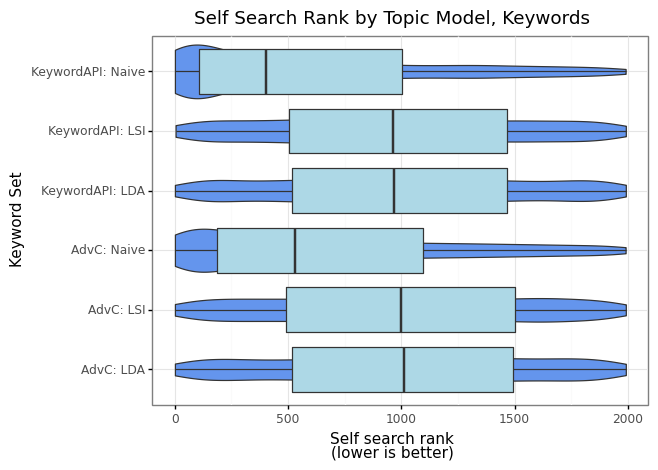

<ggplot: (8738330278205)>

In [210]:
(
    ggplot(rank_compare_df, aes(x='test',y='self_search_rank')) 
    + geom_violin(fill='#6495ED')
    + geom_boxplot(fill='#ADD8E6')    
    + theme_bw()
    + coord_flip()
    + labs(y='Self search rank\n(lower is better)',x='Keyword Set')
    + ggtitle("Self Search Rank by Topic Model, Keywords")
)

In [211]:
dist_compare_df = pd.concat(
    [x[1][['descr','self_distance','interest_id']].assign(test=x[0]) for x in dfs.items()]
)

In [212]:
dist_compare_df.loc[:,'dist_rank'] = dist_compare_df.groupby(['descr','interest_id'])['self_distance'].rank(method='dense')

In [219]:
dist_compare_df.query('interest_id==77825').sort_values('dist_rank')

,descr,self_distance,interest_id,test,dist_rank
964,Small Business Administration Cares Act Resear...,0.276490,77825,AdvC: Naive,1.0
1,Small Business Administration Cares Act Resear...,0.304923,77825,KeywordAPI: Naive,2.0
1,Small Business Administration Cares Act Resear...,0.314720,77825,KeywordAPI: LSI,3.0
964,Small Business Administration Cares Act Resear...,0.341881,77825,AdvC: LSI,4.0
1,Small Business Administration Cares Act Resear...,0.396439,77825,KeywordAPI: LDA,5.0
964,Small Business Administration Cares Act Resear...,0.484664,77825,AdvC: LDA,6.0


In [214]:
dist_compare_df.groupby(['test','dist_rank']).count().reset_index()

,test,dist_rank,descr,self_distance,interest_id
0,AdvC: LDA,1.0,16,16,16
1,AdvC: LDA,2.0,26,26,26
2,AdvC: LDA,3.0,256,256,256
3,AdvC: LDA,4.0,271,271,271
4,AdvC: LDA,5.0,1077,1077,1077
5,AdvC: LDA,6.0,345,345,345
6,AdvC: LSI,1.0,89,89,89
7,AdvC: LSI,2.0,130,130,130
8,AdvC: LSI,3.0,542,542,542
9,AdvC: LSI,4.0,236,236,236


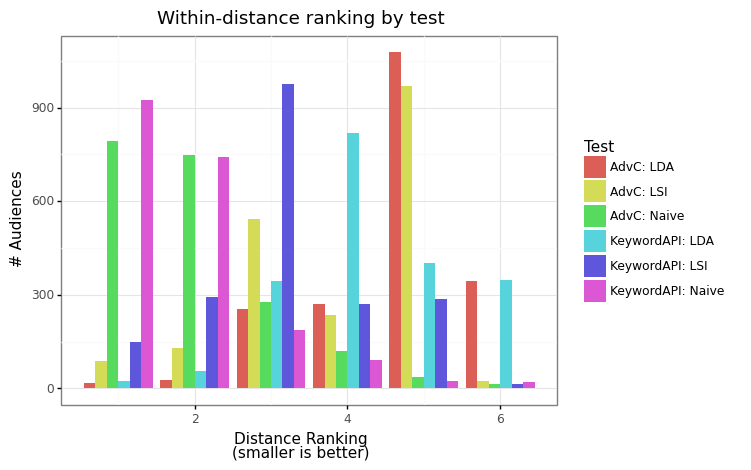

<ggplot: (8738322539277)>

In [216]:
(
    ggplot(
        dist_compare_df.groupby(['test','dist_rank']).count().reset_index(),
        aes(x='dist_rank',y='descr',fill='test')) 
    + geom_bar(stat='identity',position='dodge')
    + theme_bw()
    + labs(x='Distance Ranking\n(smaller is better)', y="# Audiences",fill='Test')
    + ggtitle("Within-distance ranking by test")
)